## Посмотрим датасет (какие столбцы есть и какие пропуски. Примем решение, что делать с пропусками)

In [23]:
import pandas as pd
from scipy.stats import f_oneway, ttest_ind, kruskal, levene, mannwhitneyu, shapiro
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('data_graduates_university_specialty_124_v20240709.csv', sep=';')

print("Общая информация о данных")
print(data.info())

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599971 entries, 0 to 599970
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   object_level       599971 non-null  object 
 1   object_name        599971 non-null  object 
 2   gender             599971 non-null  object 
 3   education_level    599971 non-null  object 
 4   year               599971 non-null  int64  
 5   university         599971 non-null  object 
 6   specialty_section  599971 non-null  object 
 7   specialty          599971 non-null  object 
 8   specialty_code     599971 non-null  object 
 9   count_graduate     599971 non-null  int64  
 10  percent_employed   599971 non-null  float64
 11  average_salary     261227 non-null  float64
 12  oktmo              599971 non-null  int64  
 13  okato              599971 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 64.1+ MB
None


In [3]:
missing_values = data.isnull().sum()
print("\nКоличество пропусков по столбцам:")
print(missing_values)


Количество пропусков по столбцам:
object_level              0
object_name               0
gender                    0
education_level           0
year                      0
university                0
specialty_section         0
specialty                 0
specialty_code            0
count_graduate            0
percent_employed          0
average_salary       338744
oktmo                     0
okato                     0
dtype: int64


### Видим много пропусков в average_salary (больше половины значений). Не будем учитывать их при анализе, так что удалим эти строки с пропусками.

In [9]:
data = data.dropna(subset=['average_salary'])
missing_values = data.isnull().sum()
print("\nКоличество пропусков по столбцам:")
print(missing_values)


Количество пропусков по столбцам:
object_level         0
object_name          0
gender               0
education_level      0
year                 0
university           0
specialty_section    0
specialty            0
specialty_code       0
count_graduate       0
percent_employed     0
average_salary       0
oktmo                0
okato                0
dtype: int64


# Гипотеза 1. Средняя зарплата зависит от уровня образования

In [16]:
# Посмотрим на уникальные уровни образования
education_levels = data['education_level'].unique()
print("Уровни образования:", education_levels)

Уровни образования: ['СПО: квалифицированные рабочие и служащие'
 'СПО: специалисты среднего звена' 'Бакалавриат, специалитет'
 'Магистратура']


In [12]:
# Группировка данных по уровню образования
groups = [data[data['education_level'] == level]['average_salary'] for level in education_levels]

In [14]:
from scipy.stats import kruskal, levene, f_oneway

# Проверка условий для ANOVA
levene_test = levene(*groups)

# Если условия равенства дисперсий соблюдаются, используем ANOVA; иначе — Краскела-Уоллиса
if levene_test.pvalue > 0.05:
    result = f_oneway(*groups)
    print("ANOVA p-value:", result.pvalue)
else:
    result = kruskal(*groups)
    print("Краскела-Уоллиса p-value:", result.pvalue)

Краскела-Уоллиса p-value: 0.0


### Вывод: p-value = 0.0 означает, что вероятность случайного возникновения таких различий крайне мала (меньше 0.05). Следовательно, можно с высокой степенью уверенности заявить, что на самом деле средняя зарплата зависит от уровня образования  

# Гипотеза 2. Доля трудоустроенных выпускников зависит от пола

In [17]:
# Разделим данные по полу
male_employed = data[data['gender'] == 'Мужской']['percent_employed']
female_employed = data[data['gender'] == 'Женский']['percent_employed']

Манна-Уитни p-value: 0.0


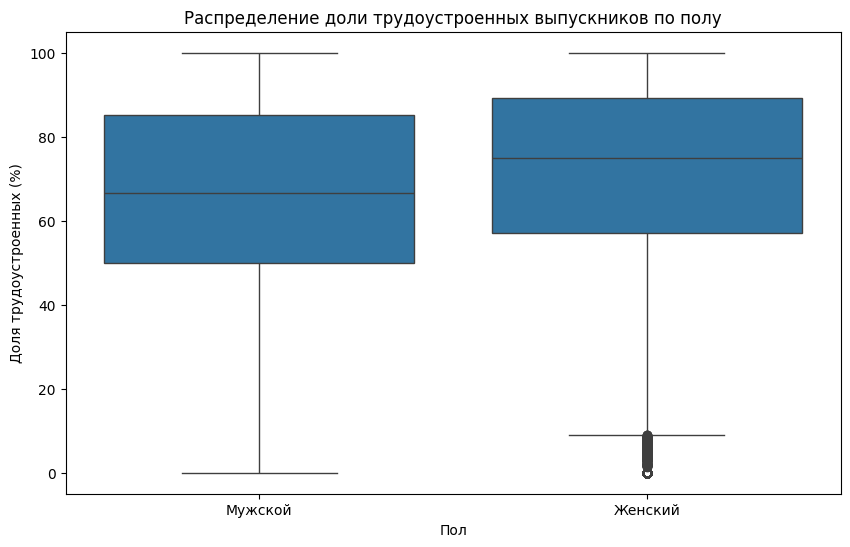

In [25]:
from scipy.stats import ttest_ind, mannwhitneyu, levene

# Разделим данные по полу
male_employed = data[data['gender'] == 'Мужской']['percent_employed']
female_employed = data[data['gender'] == 'Женский']['percent_employed']

# Проверка равенства дисперсий с помощью теста Левена
levene_test = levene(male_employed, female_employed)

# Выбор теста на основе результатов теста Левена
if levene_test.pvalue > 0.05:
    # Если дисперсии равны, используем t-тест для независимых выборок
    result = ttest_ind(male_employed, female_employed)
    print("t-тест p-value:", result.pvalue)
else:
    # В противном случае используем тест Манна-Уитни
    result = mannwhitneyu(male_employed, female_employed)
    print("Манна-Уитни p-value:", result.pvalue)

plt.figure(figsize=(10, 6))
sns.boxplot(data=data[data['gender'].isin(['Мужской', 'Женский'])], x='gender', y='percent_employed')
plt.title('Распределение доли трудоустроенных выпускников по полу')
plt.xlabel('Пол')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

## Вывод: p-value = 0.0 говорит о том, что вероятность случайного возникновения таких различий крайне мала (меньше 0.05). Это позволяет  утверждать, что доля трудоустроенных выпускников зависит от пола.
## Также можем видеть на диаграмме наличие выбросов (в женской группе), что может свидетельствовать о меньшей трудоустроенности в некоторых случаях.

# Гипотеза 3. Выпускники крупных образовательных организаций имеют более высокий процент трудоустройства

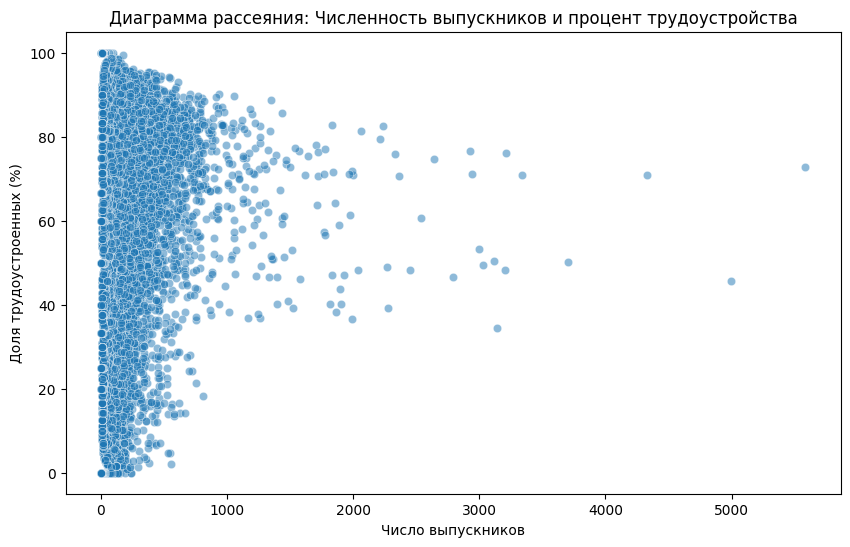

Коэффициент корреляции Спирмена: -0.115006
p-value: 0.00000000000000000000


In [29]:
from scipy.stats import pearsonr, spearmanr
# Построим диаграмму рассеяния для визуальной оценки связи
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='count_graduate', y='percent_employed', alpha=0.5)
plt.title('Диаграмма рассеяния: Численность выпускников и процент трудоустройства')
plt.xlabel('Число выпускников')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

# Рассчитаем коэффициент корреляции Спирмена
corr, p_value = spearmanr(data['count_graduate'], data['percent_employed'])

# Выведем результаты с большей точностью для p-value
print(f"Коэффициент корреляции Спирмена: {corr:.6f}")
print(f"p-value: {p_value:.20f}")

## Вывод: корреляция Спирмана слабая и отрицательная (-0.115006), но она статистически значима (p-value < 0.05). Это означает, что, хотя формально существует связь, она очень слабая и указывает на незначительное снижение процента трудоустройства с ростом численности выпускников.

# Гипотеза 4. Средняя зарплата выпускников отличается в зависимости от региона

Краскела-Уоллиса p-value: nan


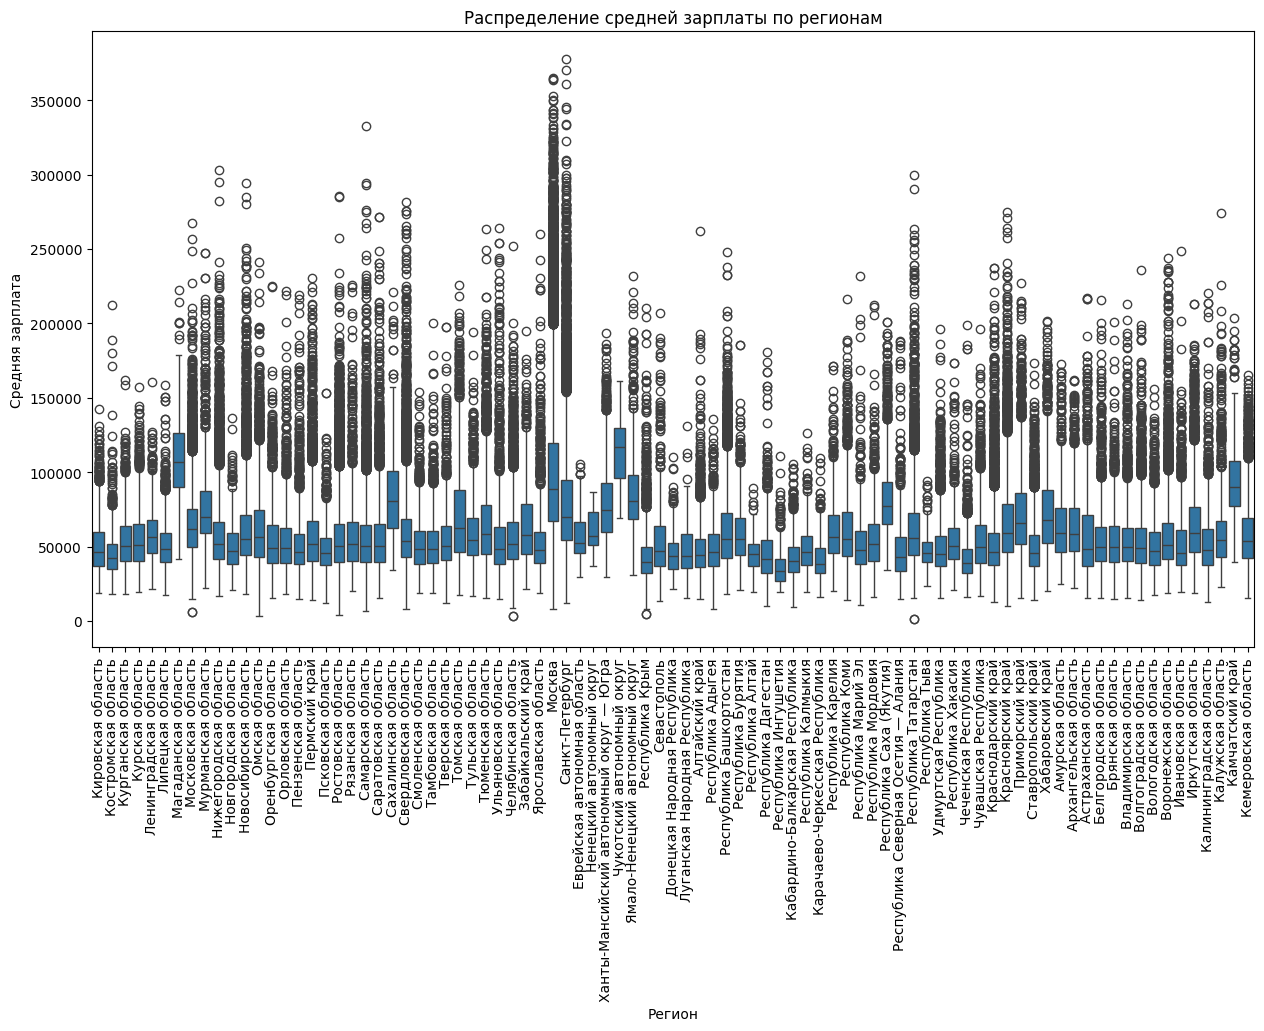

In [36]:
# Фильтруем данные, оставляя регионы с количеством значений `average_salary` >= 10
filtered_data = data.groupby('object_name').filter(lambda x: x['average_salary'].count() >= 10)

# Группировка данных по регионам для теста Краскела-Уоллиса
regions = filtered_data['object_name'].unique()
groups = [filtered_data[filtered_data['object_name'] == region]['average_salary'] for region in regions]

# Применяем тест Краскела-Уоллиса
result = kruskal(*groups)
print("Краскела-Уоллиса p-value:", result.pvalue)

# Визуализация: ящичковая диаграмма средней зарплаты по регионам
plt.figure(figsize=(15, 8))
sns.boxplot(data=filtered_data, x='object_name', y='average_salary')
plt.xticks(rotation=90)
plt.title('Распределение средней зарплаты по регионам')
plt.xlabel('Регион')
plt.ylabel('Средняя зарплата')
plt.show()

## Краскела-Уоллиса p-value: nan - может свидетельствовать о том, что в данных есть регионы с одинаковыми значениями средней зарплаты или же распределение данных в некоторых регионах вызывает проблемы при вычислении статистики.
## На ящичковой диаграмме видно, что распределение средней зарплаты между регионами сильно варьируется. Некоторые регионы имеют значительное количество выбросов, а также есть регионы с более высокими медианными значениями средней зарплаты по сравнению с другими.


In [40]:
# Фильтруем данные, оставляя регионы с количеством значений `average_salary` >= 20
filtered_data = data.groupby('object_name').filter(lambda x: x['average_salary'].count() >= 20)

# Обновляем список регионов и группы для анализа
regions = filtered_data['object_name'].unique()
print("Количество регионов после дополнительной фильтрации:", len(regions))

# Группировка данных по регионам для теста Краскела-Уоллиса
groups = [filtered_data[filtered_data['object_name'] == region]['average_salary'] for region in regions]

# Применяем тест Краскела-Уоллиса
result = kruskal(*groups)
print("Краскела-Уоллиса p-value:", result.pvalue)

Количество регионов после дополнительной фильтрации: 87
Краскела-Уоллиса p-value: nan


## Проблема с p-value: nan может быть связана с особенностями распределения данных в некоторых группах (регионах). Это может происходить из-за того, что в ряде регионов значения средней зарплаты могут быть одинаковыми или крайне близкими, что затрудняет расчет теста Краскела-Уоллиса.

## Чтобы обойти эту проблему, попробуем использовать медианные значения.

Медианные значения средней зарплаты по регионам:
object_name
Чукотский автономный округ         116616.511650
Магаданская область                106886.309000
Камчатский край                     89995.851920
Москва                              88421.131250
Сахалинская область                 80572.454100
                                       ...      
Кабардино-Балкарская Республика     40621.527500
Республика Крым                     39681.567690
Чеченская Республика                39207.231110
Карачаево-Черкесская Республика     38621.492015
Республика Ингушетия                33522.333790
Name: average_salary, Length: 87, dtype: float64


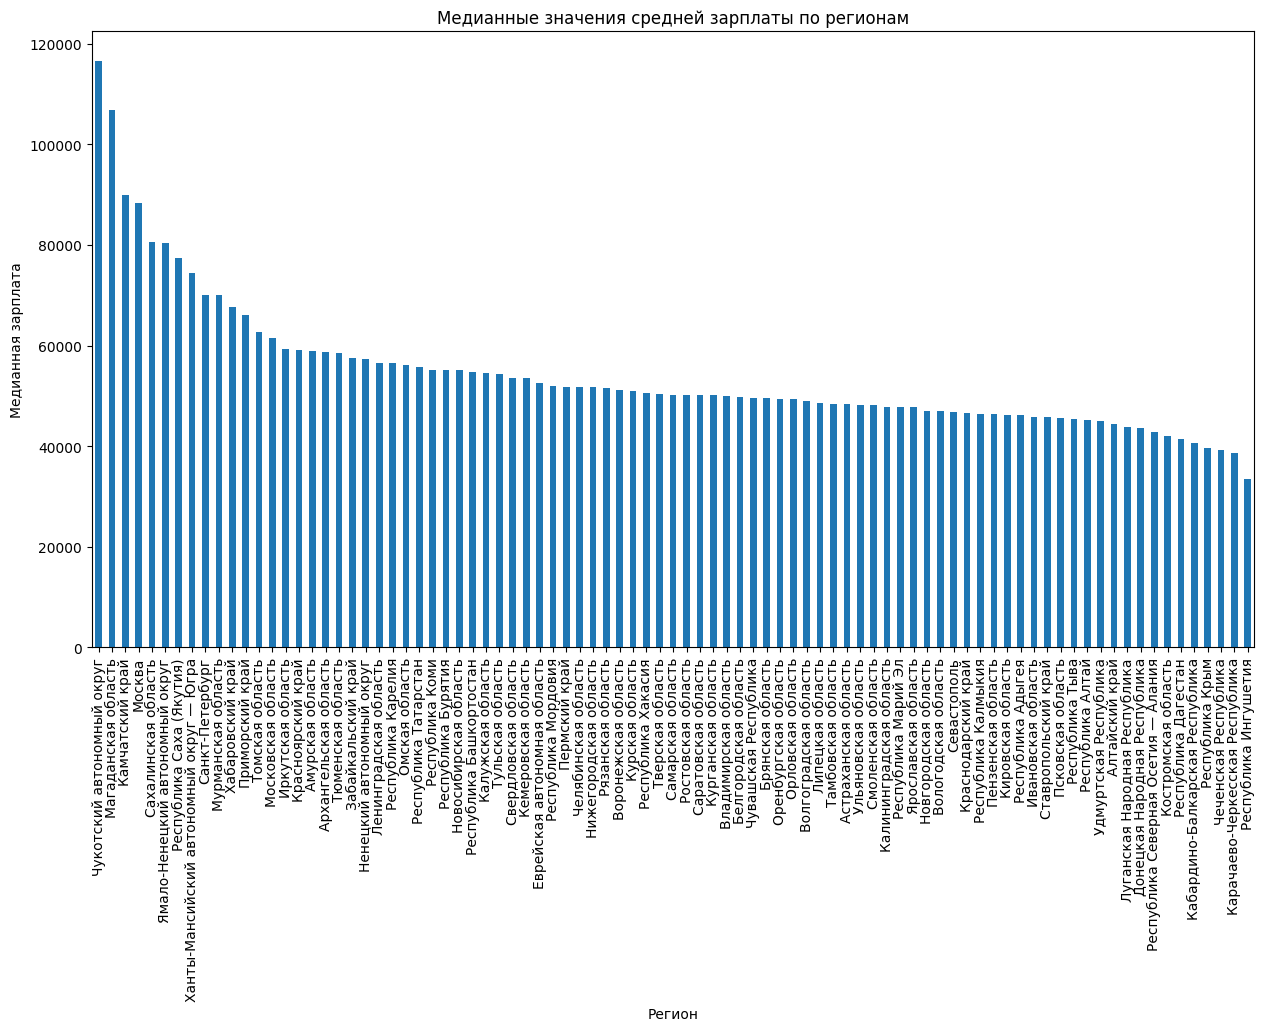

In [38]:
# Рассчитаем медианные значения средней зарплаты по регионам
median_salaries = filtered_data.groupby('object_name')['average_salary'].median()
print("Медианные значения средней зарплаты по регионам:")
print(median_salaries.sort_values(ascending=False))

# Построим визуализацию медианных значений
plt.figure(figsize=(15, 8))
median_salaries.sort_values(ascending=False).plot(kind='bar')
plt.title('Медианные значения средней зарплаты по регионам')
plt.xlabel('Регион')
plt.ylabel('Медианная зарплата')
plt.xticks(rotation=90)
plt.show()

## Вывод: Хоть и не получилось выполнить тест Краскела-Улллиса из-за технических ограничений в данных, решили использовать медианные значения средней зарплаты по регионам. По графику можем увидеть, что на самом деле есть существенное различие между мединными значениями средней зарплаты по регионам. Почти в 3,5 раза (Чукотский округ - 116616, Республика Ингушетия - 33522).

# Гипотеза 5. Доля трудоустроенных выпускников зависит от направления подготовки

In [44]:
from scipy.stats import chi2_contingency

# Создаем категорию для трудоустройства: высокая и низкая доля трудоустройства (по медиане)
median_employment = data['percent_employed'].median()
data['employment_category'] = data['percent_employed'].apply(lambda x: 'Высокая' if x >= median_employment else 'Низкая')

# Создаем таблицу сопряженности для направлений подготовки и категорий трудоустройства
contingency_table = pd.crosstab(data['specialty_section'], data['employment_category'])
print("Таблица сопряженности:\n", contingency_table)

# Применяем χ²-тест
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("χ²-тест p-value:", p_value)


Таблица сопряженности:
 employment_category                                 Высокая  Низкая
specialty_section                                                  
Авиационная и ракетно-космическая техника              1679     568
Архитектура                                            1840    1937
Аэронавигация и эксплуатация авиационной и раке...      767     551
Биологические науки                                    2066    1163
Ветеринария и зоотехния                                2851    3226
Изобразительное и прикладные виды искусств             4020    9992
Информатика и вычислительная техника                  19252   19984
Информационная безопасность                            2914    1810
Искусствознание                                         534     478
История и археология                                   3330    3037
Клиническая медицина                                   6161    5154
Компьютерные и информационные науки                    1741     951
Культуроведение и социок

<Figure size 1200x800 with 0 Axes>

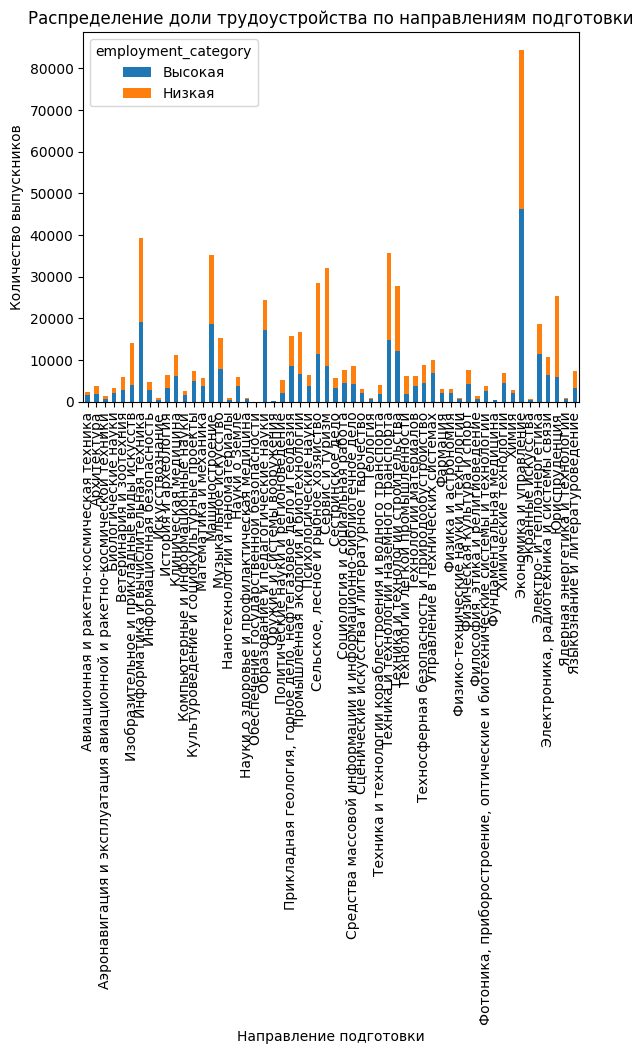

In [45]:
plt.figure(figsize=(12, 8))
contingency_table.plot(kind='bar', stacked=True)
plt.title('Распределение доли трудоустройства по направлениям подготовки')
plt.xlabel('Направление подготовки')
plt.ylabel('Количество выпускников')
plt.xticks(rotation=90)
plt.show()

## Выводы: χ²-тест p-value: 0.0 - указывает на статистически значимую зависимость между направлением подготовки и долей трудоустроенных выпускников.
## Таким образом, мы подтверждаем гипотезу 5: доля трудоустроенных выпускников зависит от направления подготовки.

## Мини-выводы по графику и таблице: 
1) Топ-3 направления с высоким уровнем трудоустройства - Экономика и управление, информатика и вычислительная техника, машиностроение.
2) Экономика и управление — направление с большим числом выпускников, но высокий процент также приходится на низкую долю трудоустройства. Это может говорить о переполненности рынка труда специалистами в экономике, что усложняет трудоустройство выпускников.
3) Некоторые направления, такие как обеспечение государственной безопасности, имеют очень небольшое количество выпускников, но почти все из них имеют высокую долю трудоустройства.
4) Направления, такие как сценические искусства и литературное творчество, теология, и философия, этика и религиоведение имеют значительно больше выпускников с низкой долей трудоустройства. Это может указывать на ограниченные карьерные перспективы для выпускников в этих областях и высокую конкуренцию за рабочие места.
5) Направления, такие как информатика и вычислительная техника, образование и педагогические науки, техника и технологии наземного транспорта, имеют значительное количество выпускников с высокой долей трудоустройства. Это может свидетельствовать о высоком спросе на специалистов в этих областях.

# Общие выводы по гипотезам:
1) Средняя зарплата зависит от уровня образования: Выпускники с высшим образованием в среднем получают более высокую зарплату, что подтверждает влияние уровня образования на доходы.
2) Доля трудоустроенных выпускников зависит от пола: Между мужчинами и женщинами существуют статистически значимые различия в уровне трудоустройства, что может отражать особенности спроса на специалистов в зависимости от пола.
3) Выпускники крупных образовательных организаций имеют более высокий процент трудоустройства: Размер учебного заведения слабо влияет на трудоустройство; выпускники крупных учреждений сталкиваются с конкуренцией, что снижает общий уровень трудоустройства.
4) Средняя зарплата выпускников отличается в зависимости от региона: Уровень средней зарплаты сильно варьируется по регионам, причем наибольшие доходы наблюдаются в северных и столичных регионах, где затраты на жизнь и спрос на специалистов выше.
5) Доля трудоустроенных выпускников зависит от направления подготовки: Направление подготовки существенно влияет на трудоустройство — высокие показатели отмечены в IT, строительстве и медицине, а низкие в гуманитарных и творческих направлениях.